# Проект: классификация

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing, feature_selection
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [165]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

Посмотрим на полученные данные

In [166]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


С первого взгляда видно что данные в непригодном для составления модели виде. Сразу можно отметить что день и месяц моно преобразовать в один признак даты. Проверим типы данных в таблице

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Большая часть данных представлена в виде *object*, как можно заметить признак *balance* тоже представлен типом объект, из-за символа *$* в конце. Проверим все данные типа *object* на количество уникальных значений чтобы иметь представления какими типами кодировки можно воспользоваться

In [168]:
df.loc[:, df.dtypes == 'object'].nunique()

job            12
marital         3
education       4
default         2
balance      3802
housing         2
loan            2
contact         3
month          12
poutcome        4
deposit         2
dtype: int64

Все признаки кроме *job* имеют довольно небольшое количество зачений. Для всех этих признаков будет достаточно *OneHot* кодирования. По признаку *job* решение примем позже, после дальнейшего анализа данных. Проверим еще количество пропусков в данных.

In [169]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [170]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [171]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df[df['balance'].notnull()]['balance'].apply(lambda x: float(x[:-2].replace(' ', '').replace(',', '.')))

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [173]:
df['balance'].mean()

1529.1290293615875

### Задание 4

In [174]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df['balance'].median(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [175]:
df['balance'].mean().round(3)

1526.936

### Задание 5

In [176]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
print(df['job'].unique())
print(df['education'].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
['secondary' 'tertiary' 'primary' 'unknown']


In [177]:
df.replace({'job':['unknown'], 'education':['unknown']}, 
           {'job':df['job'].mode(), 'education':df['education'].mode()}, 
           inplace=True)

In [178]:
print(df['job'].unique())
print(df['education'].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']
['secondary' 'tertiary' 'primary']


In [179]:
df[(df['job']==df['job'].mode()[0])&(df['education']==df['education'].mode()[0])]['balance'].mean().round(3)

1598.883

In [180]:
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 6

In [181]:
# удалите все выбросы для признака balance
bottom = df['balance'].quantile(0.25) - 1.5*(df['balance'].quantile(0.75) - df['balance'].quantile(0.25))
top = df['balance'].quantile(0.75) + 1.5*(df['balance'].quantile(0.75) - df['balance'].quantile(0.25))
print(bottom, top)

-2241.0 4063.0


In [182]:
df.shape

(11162, 17)

In [183]:
df = df.loc[(df['balance']<=top)&(df['balance']>=bottom)]

In [184]:
df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

Text(0.5, 1.0, 'Распределение клиентов по целевому признаку')

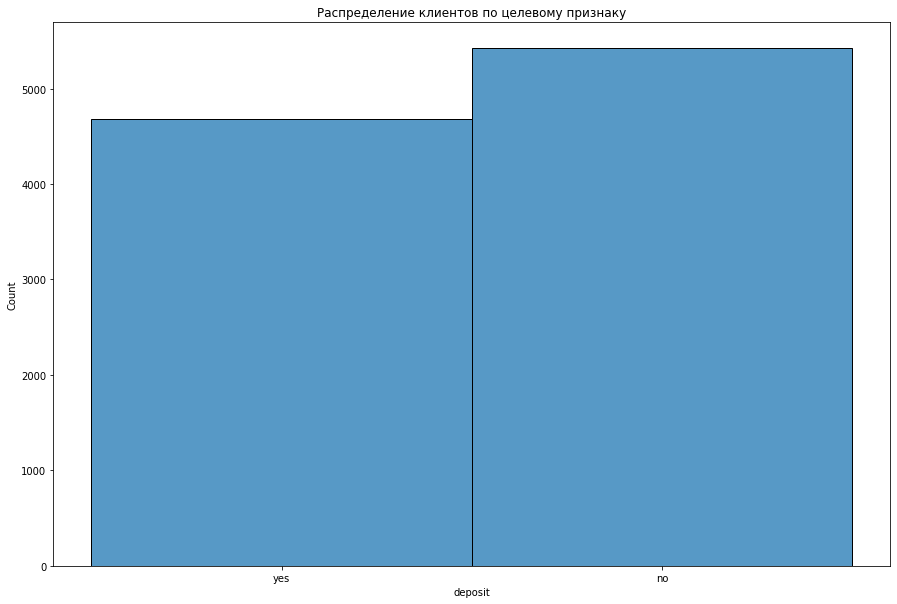

In [185]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = plt.figure(figsize=(15,10))
hist = sns.histplot(df['deposit'], binwidth=100)
hist.set_title('Распределение клиентов по целевому признаку')

In [186]:
(df['deposit']=='yes').sum()

4681

In [187]:
df.loc[:, df.dtypes != 'object']

,age,balance,day,duration,campaign,pdays,previous
0,59,2343.0,5,1042,1,-1,0
1,56,45.0,5,1467,1,-1,0
2,41,1270.0,5,1389,1,-1,0
3,55,2476.0,5,579,1,-1,0
4,54,184.0,5,673,2,-1,0
...,...,...,...,...,...,...,...
11157,33,1.0,20,257,1,-1,0
11158,39,733.0,16,83,4,-1,0
11159,32,29.0,19,156,2,-1,0
11160,43,0.0,8,9,2,172,5


In [188]:
col_no_object = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
print(col_no_object)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [189]:
df[col_no_object].describe()

,age,balance,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 2 и 3

In [190]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df[col_no_object].describe()

,age,balance,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,3881.000000,43.000000,854.000000,58.000000


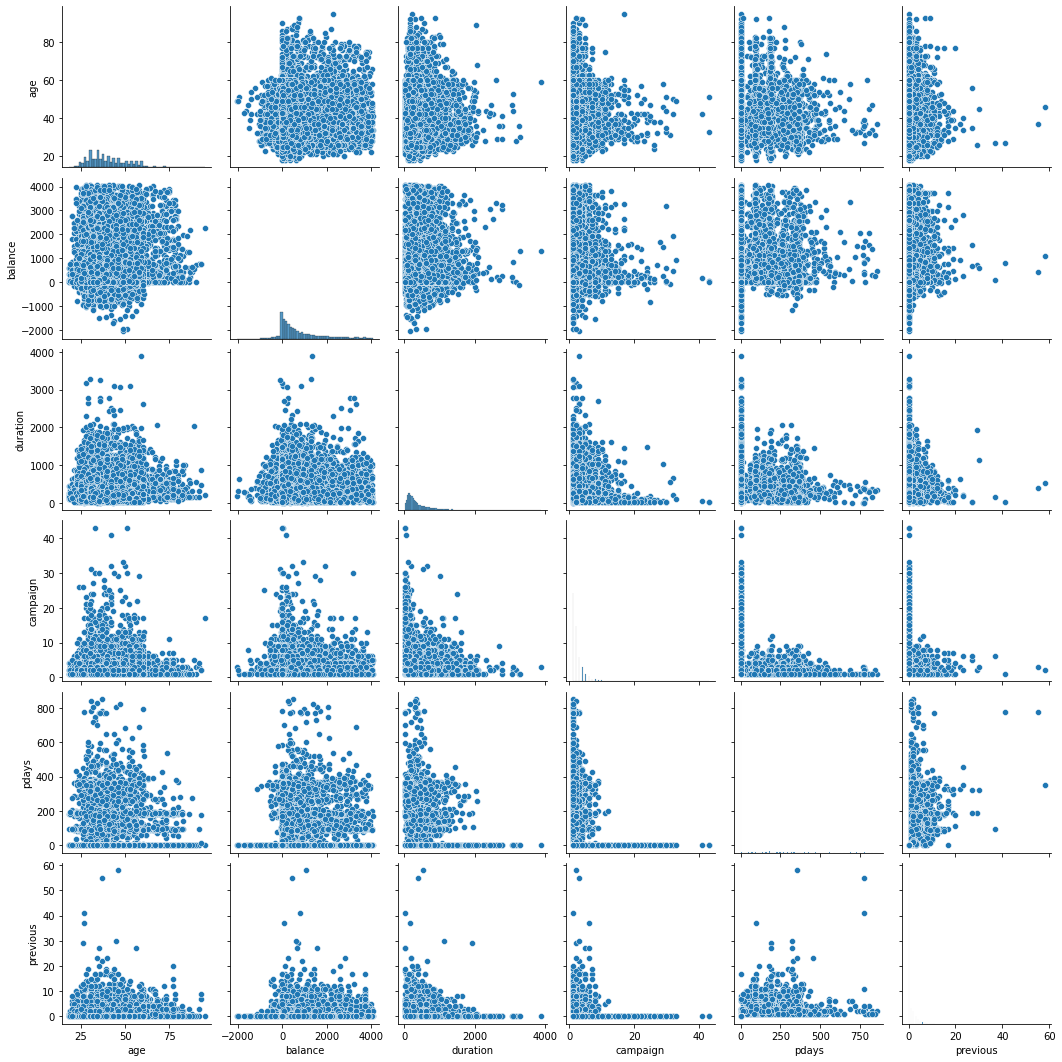

In [191]:
sns.pairplot(df[col_no_object])

### Задания 4 и 5

In [192]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
col_object = df.loc[:, df.dtypes == 'object'].columns
df[col_object].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

Text(0.5, 1.0, 'Распределение результатов предыдущей и текущей кампаний')

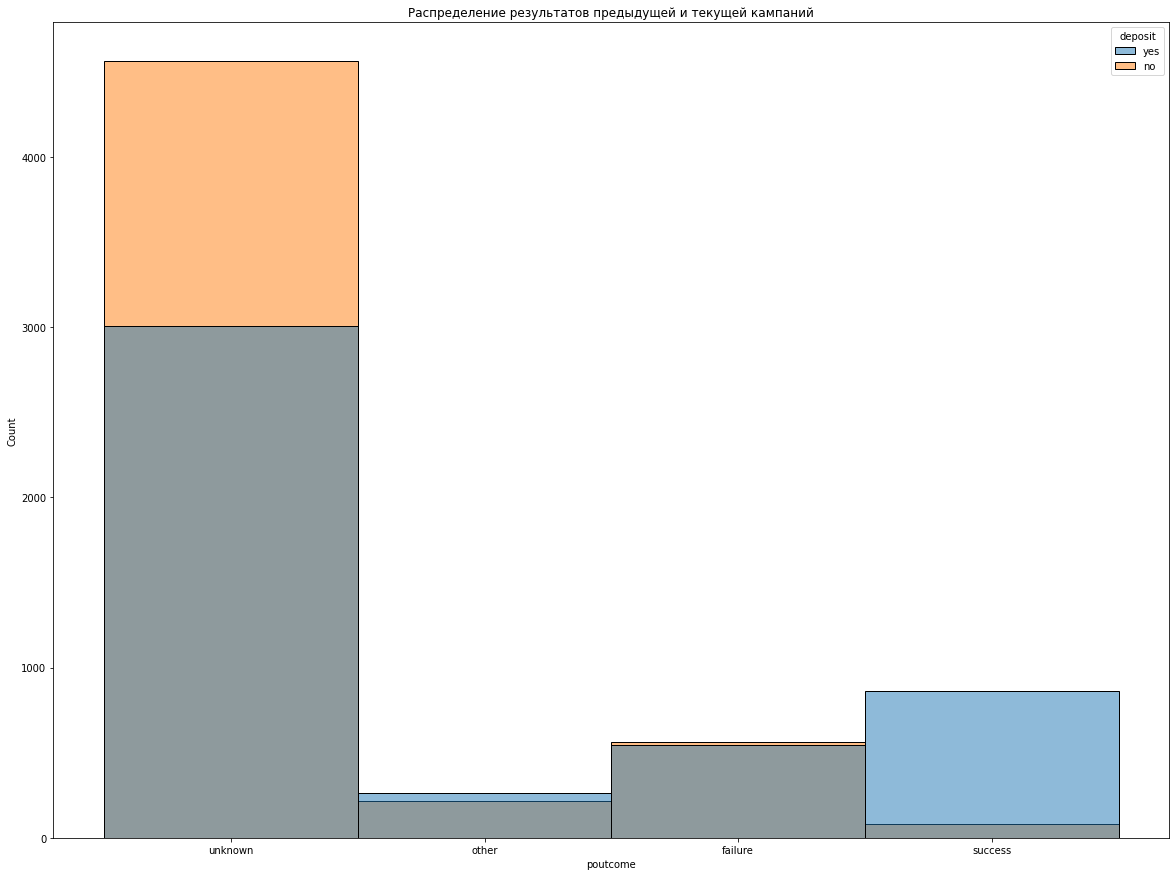

In [193]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
fig = plt.figure(figsize=(20,15))
hist2 = sns.histplot(x='poutcome', data=df, hue='deposit')
hist2.set_title('Распределение результатов предыдущей и текущей кампаний')

### Задание 7

In [194]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df2 = df.copy()
df2['deposit'] = df2['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df2.groupby('month')['deposit'].agg('mean')

month
apr    0.618072
aug    0.440433
dec    0.903226
feb    0.544429
jan    0.391850
jul    0.410437
jun    0.451087
mar    0.898734
may    0.321360
nov    0.415385
oct    0.814925
sep    0.834532
Name: deposit, dtype: float64

### Задание 8

In [195]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def search_age_group(age):
    if age < 30:
        return '<30'
    elif age < 40:
        return '30-40'
    elif age < 50:
        return '40-50'
    elif age < 60:
        return '50-60'
    else:
        return '60+'
    
df['age_group'] = df['age'].apply(search_age_group)
df.drop('age', axis=1, inplace=True)
df.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


Text(0.5, 1.0, 'Распределение результатов текущей кампаний по возрастным категориям')

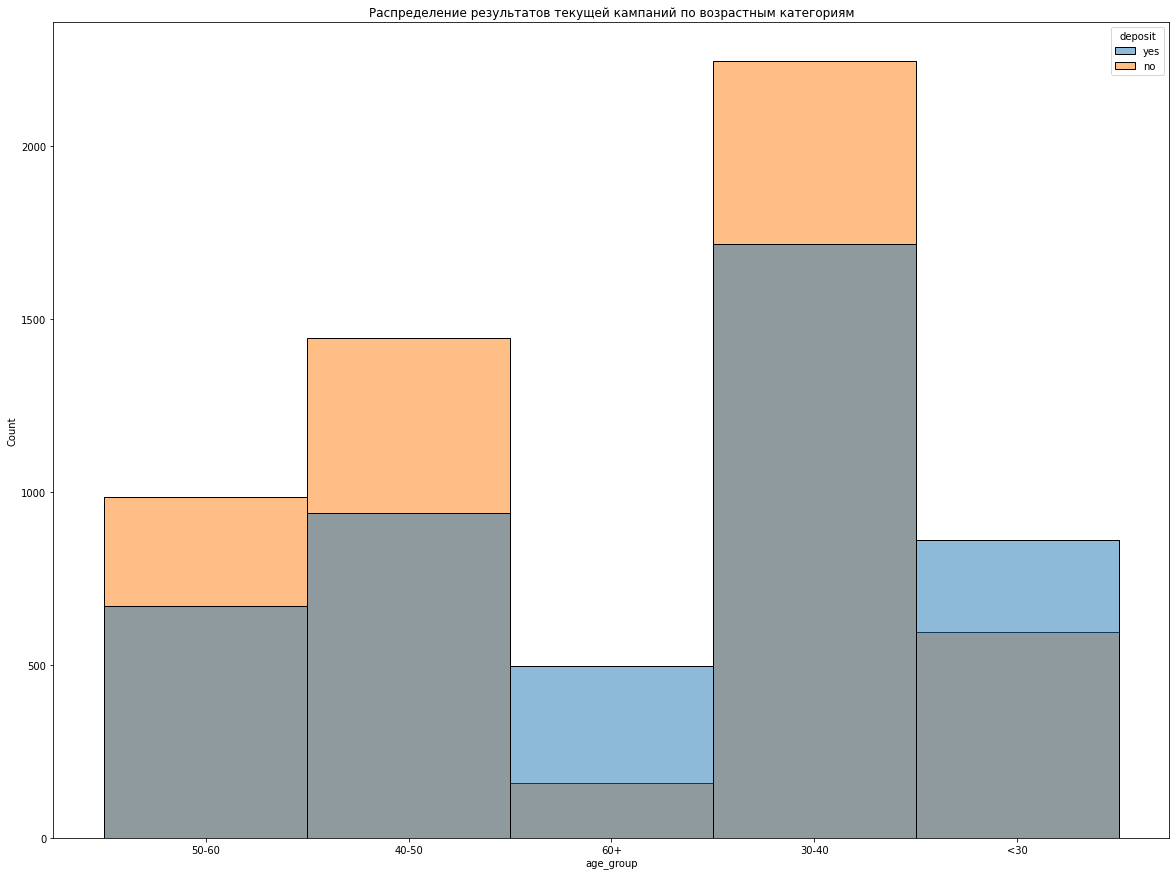

In [196]:
fig = plt.figure(figsize=(20,15))
hist2 = sns.histplot(x='age_group', data=df, hue='deposit')
hist2.set_title('Распределение результатов текущей кампаний по возрастным категориям')

### Задания 9 и 10

Text(0.5, 1.0, 'Распределение результатов текущей кампаний по семейному статусу')

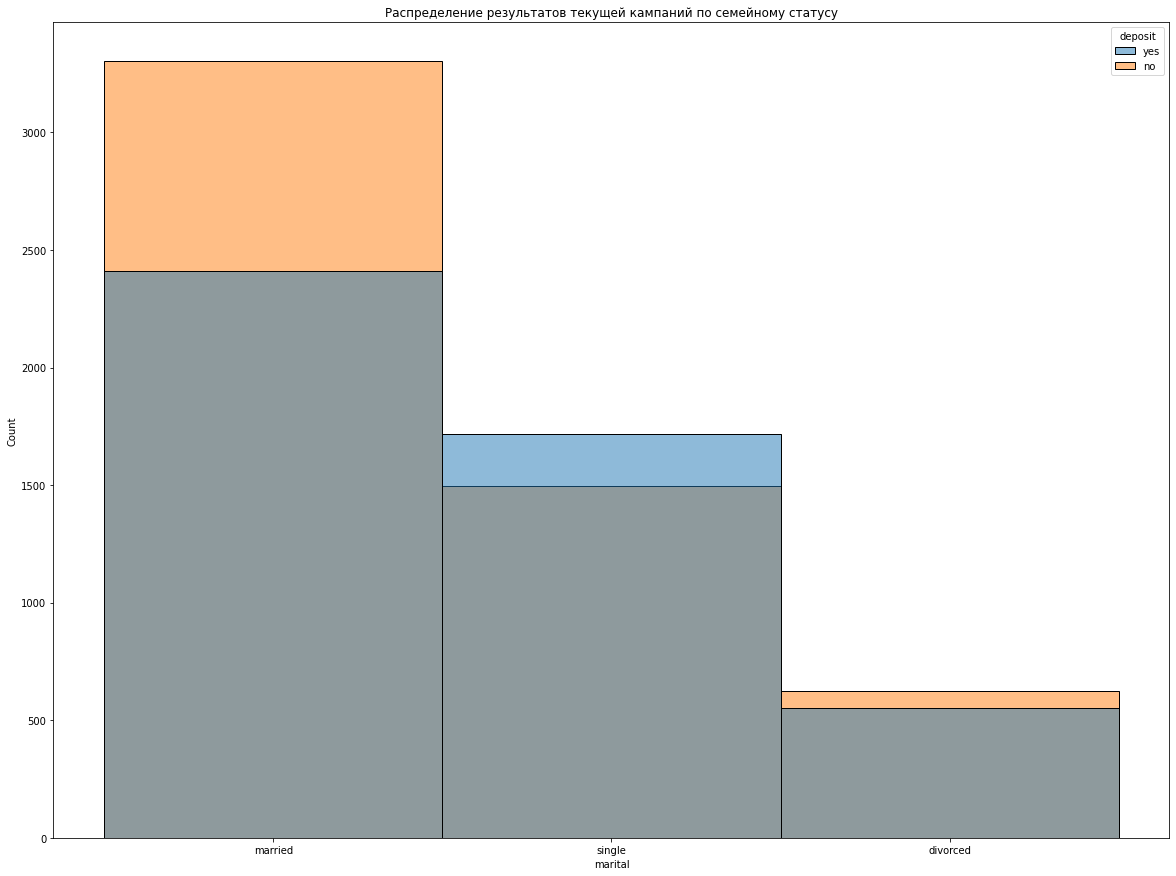

In [197]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(20,15))
hist2 = sns.histplot(x='marital', data=df, hue='deposit')
hist2.set_title('Распределение результатов текущей кампаний по семейному статусу')

Text(0.5, 1.0, 'Распределение результатов текущей кампаний по уровню образования')

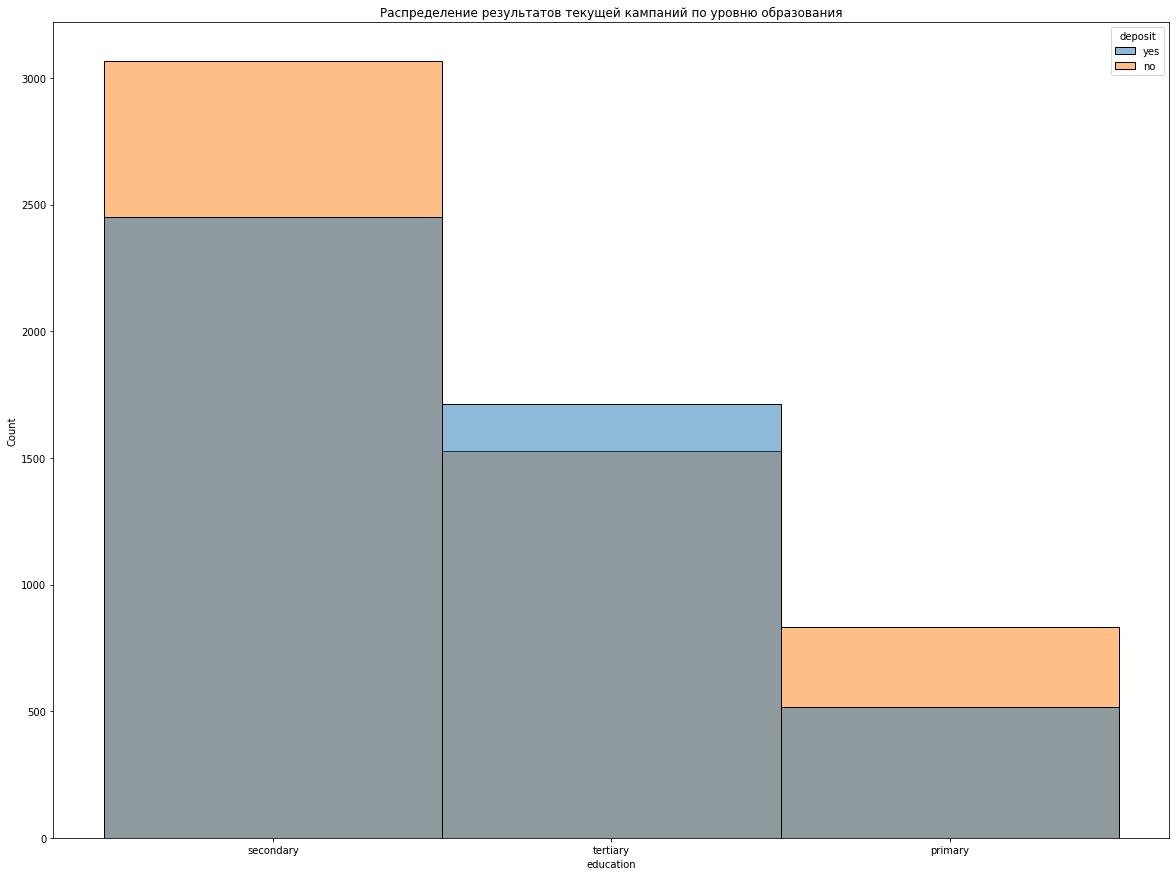

In [198]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(20,15))
hist2 = sns.histplot(x='education', data=df, hue='deposit')
hist2.set_title('Распределение результатов текущей кампаний по уровню образования')

Text(0.5, 1.0, 'Распределение результатов текущей кампаний по профессиям')

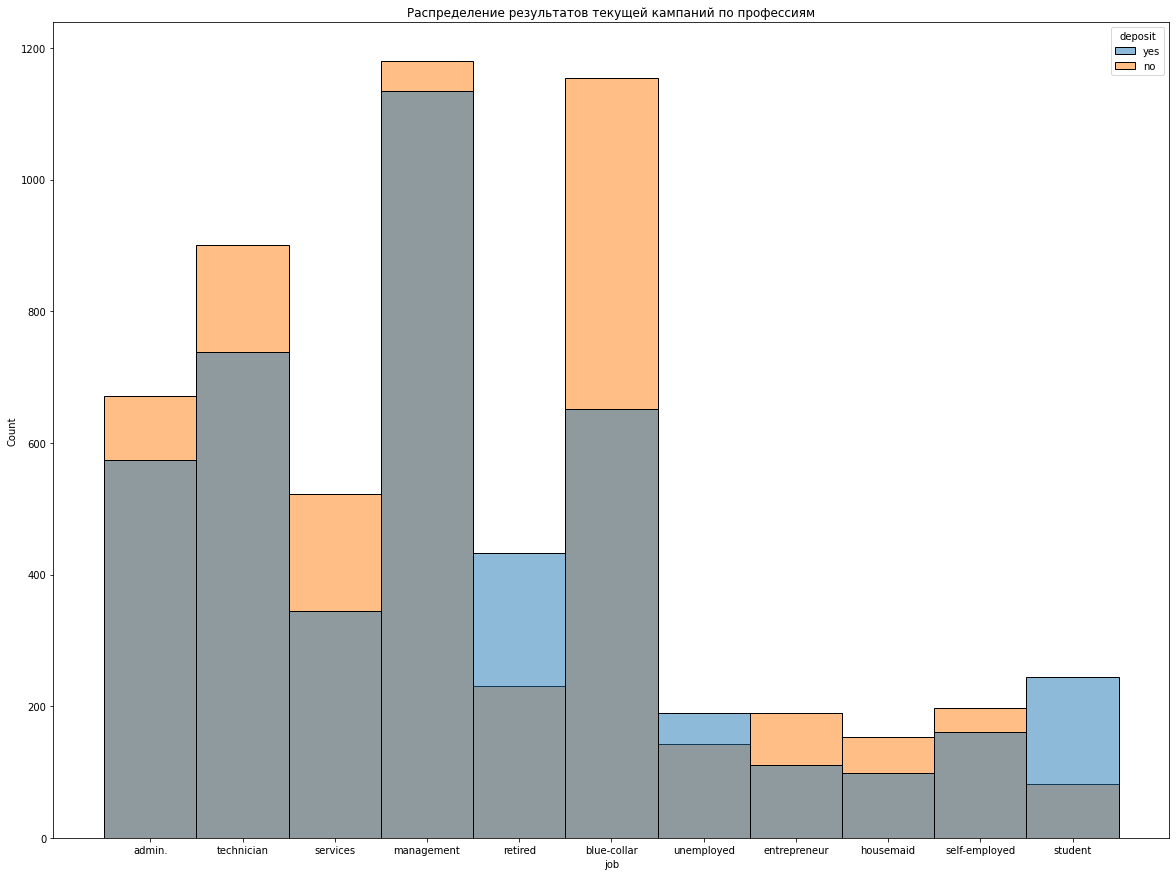

In [199]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(20,15))
hist2 = sns.histplot(x='job', data=df, hue='deposit')
hist2.set_title('Распределение результатов текущей кампаний по профессиям')

### Задание 11

In [200]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df3 = df.copy()
df3['deposit'] = df3['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df2.groupby(['marital', 'education'])['deposit'].agg('count')

marital   education
divorced  primary       187
          secondary     653
          tertiary      337
married   primary       980
          secondary    3119
          tertiary     1616
single    primary       182
          secondary    1745
          tertiary     1286
Name: deposit, dtype: int64

In [201]:
df2.groupby(['marital', 'education'])['deposit'].agg('sum')

marital   education
divorced  primary        96
          secondary     283
          tertiary      174
married   primary       339
          secondary    1289
          tertiary      784
single    primary        82
          secondary     879
          tertiary      755
Name: deposit, dtype: int64

In [202]:
df2.groupby(['marital', 'education'])['deposit'].agg('mean')

marital   education
divorced  primary      0.513369
          secondary    0.433384
          tertiary     0.516320
married   primary      0.345918
          secondary    0.413273
          tertiary     0.485149
single    primary      0.450549
          secondary    0.503725
          tertiary     0.587092
Name: deposit, dtype: float64

## Часть 3: преобразование данных

### Задание 1

In [203]:
# преобразуйте уровни образования
lb_encod = LabelEncoder()
lb_encod.fit(df['education'])
print(lb_encod.classes_)
df['education'] = lb_encod.transform(df['education'])
df.head()


['primary' 'secondary' 'tertiary']


,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


In [204]:
df['education'].sum()

11995

In [205]:
lb_encod = LabelEncoder()
lb_encod.fit(df['age_group'])
print(lb_encod.classes_)
df['age_group'] = lb_encod.transform(df['age_group'])
df.head()

['30-40' '40-50' '50-60' '60+' '<30']


,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [206]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [207]:
df.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [208]:
df['deposit'].std().round(3)

0.499

In [209]:
round(df['default'].mean() + df['loan'].mean() + df['housing'].mean(), 3)

0.635

### Задание 4

In [210]:
# создайте дамми-переменные
df_oh = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, df_oh], axis=1)
df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1, inplace=True)
df.head()

,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,0,2343.0,1,0,5,1042,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,45.0,0,0,5,1467,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,0,1270.0,1,0,5,1389,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,2476.0,1,0,5,579,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,2,0,184.0,0,0,5,673,2,-1,0,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

<AxesSubplot:>

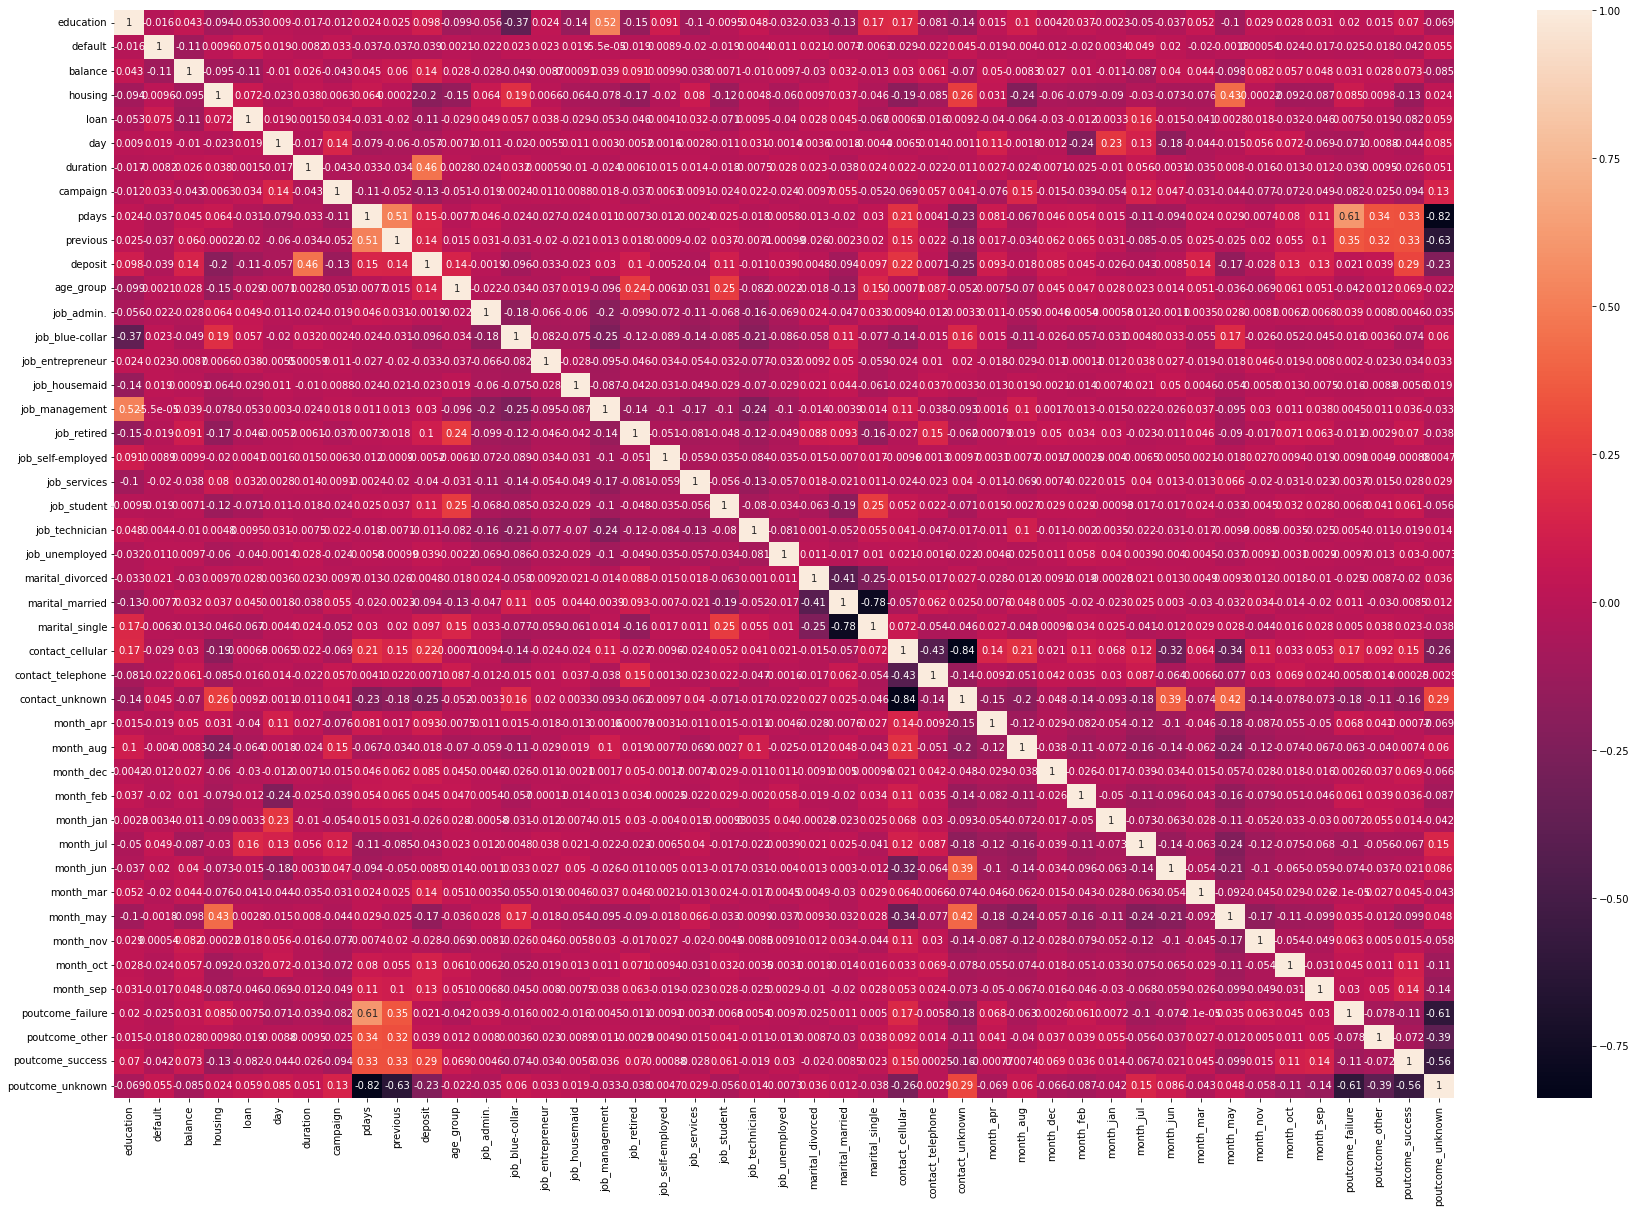

In [211]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)

### Задания 7 и 8

In [212]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [213]:
# рассчитайте необходимые показатели
X_test.shape
y_test.mean().round(2)

0.46

### Задание 9

In [214]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
select = SelectKBest(f_classif, k=15)
select.fit(X_train, y_train)
features_select = select.get_feature_names_out()
print(features_select)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [215]:
X_train = X_train[features_select]
X_test = X_test[features_select]

### Задание 10

In [216]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [217]:
X_test_scaled[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [218]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, n_jobs=-1, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
round(metrics.accuracy_score(y_test, log_reg.predict(X_test_scaled)), 2)

0.8

### Задания 2,3,4

In [219]:
# обучите решающие деревья, настройте максимальную глубину
dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_train, dtc.predict(X_train_scaled)))
print(metrics.classification_report(y_test, dtc.predict(X_test_scaled)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



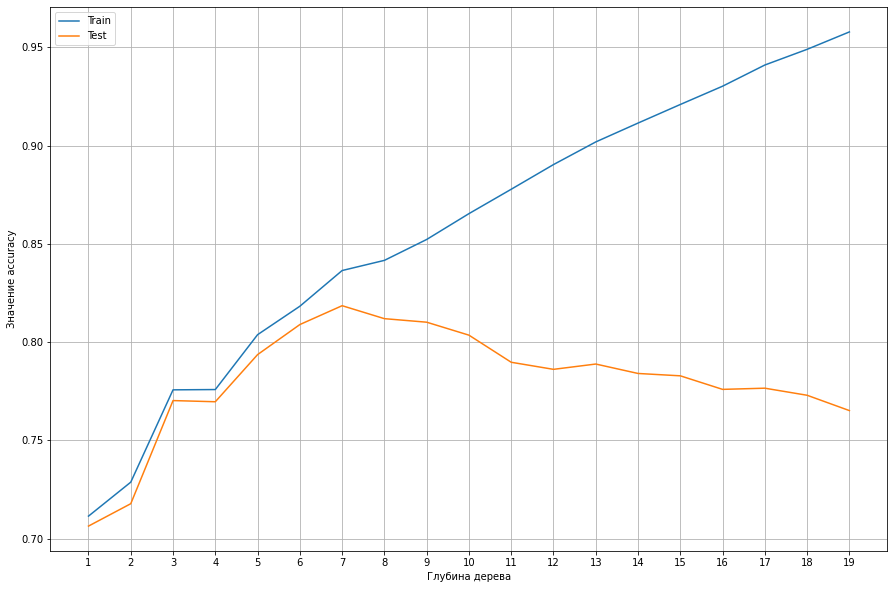

In [220]:
accuracy_test = []
accuracy_train = []
depths = range(1, 20)
for depth in depths:
    dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)
    dtc.fit(X_train_scaled, y_train)
    accuracy_train.append(metrics.accuracy_score(y_train, dtc.predict(X_train_scaled)))
    accuracy_test.append(metrics.accuracy_score(y_test, dtc.predict(X_test_scaled)))
    
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(depths, accuracy_train, label='Train')
ax.plot(depths, accuracy_test, label='Test')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Значение accuracy')
ax.xaxis.set_ticks(depths)
ax.grid()
ax.legend()

In [221]:
dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7)
dtc.fit(X_train_scaled, y_train)
print(round(metrics.accuracy_score(y_train, dtc.predict(X_train_scaled)), 2))
print(round(metrics.accuracy_score(y_test, dtc.predict(X_test_scaled)), 2))

0.84
0.82


### Задание 5

In [222]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10] ,
              'max_depth':[3,5,7]
              }
grid_search =  GridSearchCV(
        estimator=tree.DecisionTreeClassifier(
            criterion='entropy', 
            random_state=42
        ), 
    param_grid=param_grid,
     
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 78.1 ms
Wall time: 1.69 s
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [223]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [224]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gbc = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
gbc.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, gbc.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [228]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('log_reg', log_reg),
    ('dtc', dtc),
    ('gbc', gbc)
]

model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(),
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [238]:
X_train.columns

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [259]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
coef = pd.DataFrame(gbc.feature_importances_, index=X_train.columns)
coef.sort_values(by=0, ascending=False).transpose()

,duration,poutcome_success,contact_unknown,balance,pdays,housing,age_group,month_mar,month_oct,campaign,month_may,month_sep,previous,contact_cellular,poutcome_unknown
0,0.501987,0.116264,0.073762,0.059764,0.055647,0.046583,0.042102,0.026144,0.018824,0.017101,0.014508,0.013428,0.008901,0.0046,0.000386


### Задания 6,7,8

In [260]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42,
                                          n_jobs=-1)
  
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [261]:
%%time

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

[I 2023-05-25 12:15:35,059] A new study created in memory with name: RandomForestClassifier
[I 2023-05-25 12:15:35,735] Trial 0 finished with value: 0.8448844884488449 and parameters: {'n_estimators': 145, 'max_depth': 29, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8448844884488449.
[I 2023-05-25 12:15:36,357] Trial 1 finished with value: 0.8454159459034439 and parameters: {'n_estimators': 132, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8454159459034439.
[I 2023-05-25 12:15:37,326] Trial 2 finished with value: 0.8628187079618332 and parameters: {'n_estimators': 188, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8628187079618332.
[I 2023-05-25 12:15:38,019] Trial 3 finished with value: 0.8535211267605634 and parameters: {'n_estimators': 144, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8628187079618332.
[I 2023-05-25 12:15:38,948] Trial 4 finished with value: 0.8624512099921936 and parameters: {'

CPU times: total: 5.77 s
Wall time: 15.1 s


In [262]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 21, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [264]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
